In [26]:
from tensorflow.keras import *
from tensorflow.keras.layers import * 
import tensorflow as tf
import numpy as np
from tensorflow.python.framework.ops import disable_eager_execution
from keras.callbacks import TensorBoard
from datetime import datetime
from keras.callbacks import EarlyStopping

# disable_eager_execution()


Using TensorFlow backend.


In [3]:
tf.executing_eagerly()

True

In [4]:
def create_encoder(encoder_input, num_layers=2, hidden_size=128):
    
    for i in range(num_layers):
        if i == 0:
            output, hidden = GRU(units=hidden_size, dropout=0.3, 
                                 return_sequences=True, return_state=True, kernel_initializer='he_normal')(encoder_input)
        else:
            output, hidden = GRU(units=hidden_size, dropout=0.3, 
                                 return_sequences=True, 
                                 return_state=True,kernel_initializer='he_normal')(output, initial_state=hidden)
    
    return output, hidden

In [5]:
cat_dict = {
        'event_name_1': {'input_dim': 31, 'output_dim': 1},
        'event_type_1': {'input_dim': 5, 'output_dim': 1},
        'event_name_2': {'input_dim': 5, 'output_dim': 1},
        'event_type_2': {'input_dim': 5, 'output_dim': 1},

        'item_id': {'input_dim': 3049, 'output_dim': 3},
        'dept_id': {'input_dim': 7, 'output_dim': 1},
        'store_id': {'input_dim': 10, 'output_dim': 1},
        'cat_id': {'input_dim': 3, 'output_dim': 1},
        'state_id': {'input_dim': 3, 'output_dim': 1},  
#         'wday': {'input_dim': 7, 'output_dim': 1}, 
#         'month': {'input_dim': 12, 'output_dim': 1}, 
#         'year': {'input_dim': 6, 'output_dim': 1}, 
#         'day': {'input_dim': 31, 'output_dim': 1}, 
           }
cat_cols = list(cat_dict.keys())


In [19]:
class build_model(object):
    def __init__(self, seq_len, dec_seq_len, num_cont_features, categorical_details={},  dec_num_layers=2, hidden_size=128, teacher_forcing=False, batch_size=10):
        self.seq_len = seq_len
        self.dec_seq_len = dec_seq_len
        self.num_features = num_cont_features
        self.dec_hidden_size = hidden_size
        self.categorical_details = categorical_details
        self.hidden_size = hidden_size
        self.teacher_forcing = teacher_forcing
        self.batch_size = batch_size 
        self.num_layers = dec_num_layers

    def create_cat_inputs_embeddings(self):
        catInputs = []
        embeddings_cat = []
        for feature_name, embedding_params in self.categorical_details.items():
            feature_input = Input(shape=(self.seq_len,), name=feature_name)
            catInputs.append(feature_input)
            embedding = Embedding(**embedding_params)(feature_input)
            embeddings_cat.append(embedding)

        return catInputs, embeddings_cat

    def build_encoder_model(self):
        # get inputs 
        self.encoder_input_cont = Input(shape=(self.seq_len, self.num_features), name='continous_features') 
        # create embeddings for categoricals and concat features with continous features
        if self.categorical_details:
            self.catInputs, embeddings_cat = self.create_cat_inputs_embeddings()
            # input to encoder -> concatenate continous and categorial features
            encoder_input = concatenate([self.encoder_input_cont] + embeddings_cat)
        else:
            self.catInputs = []
            encoder_input = self.encoder_input_cont  
        # saving encoder state to self for inference 
        self.enc_output, self.enc_state = create_encoder(num_layers=2, hidden_size=128, 
                                                   encoder_input=encoder_input)
        
    def create_decoder_cells(self, decoder_input, decoder_hidden):
        """
        Creates a RNN layer vertically at timestep N. 
        Inputs: 
            decoder_input is input at one timestep - shape (batch_size, 1)
            decoder_hidden: - initial hidden state at layer 0 - shape- (batch_size, hidden_size)
        output:
            (batch_size, hidden_size)
        """            
        if self.dec_hidden_size != decoder_hidden.shape[-1] or len(decoder_hidden.shape)>2:
            raise ValueError('Hidden size is {} but decoder input has shape {}'.format(dec_hidden_size, decoder_hidden.shape))
#         print('decoder input shape {} and decoder hidden shape {} '.format(decoder_input.shape, decoder_hidden.shape))
        for i in range(self.num_layers):
            out, decoder_hidden = GRUCell(units=self.dec_hidden_size, 
                                          kernel_initializer='he_normal')(decoder_input, decoder_hidden)
            decoder_input = out

        return out, decoder_hidden

    def create_decoder(self, decoder_input, decoder_hidden): 
        """
        Creates decoder
        Input: Initial decoder hidden state. Will be passing encoder output hidden state 
        decoder input: (batch_size, dec_seq_len)
        """
        outputs = []
#         self.batch_size=self.encoder_input_cont.shape[0]
        if not self.teacher_forcing:
#             decoder_input = tf.zeros((self.batch_size, 1))
            for i in range (self.dec_seq_len):
                o, h = self.create_decoder_cells(decoder_input, decoder_hidden)
                # FC layers 
                o = Dense(1)(o)
                outputs.append(o)
                # output of at timestep N is input at N+1
                decoder_input = o 
                # layers.GRUCell returns hidden state of type List
                decoder_hidden=h[0]
        else:
            for i in range(self.dec_seq_len):
                # feeding in target (decoder input) at time T into decoder at time T+1.
                # first element of sequence of decoder_input padded with zeros prior
                decoder_input_t = tf.expand_dims(decoder_input[:, i], axis=1)
#                 decoder_input_t=f.stop_gradient(decoder_input_t)
                o, h = self.create_decoder_cells(decoder_input_t, decoder_hidden)
                # layers.GRUCell returns hidden state of type List
                o = Dense(1)(o)
                outputs.append(o)
                decoder_hidden=h[0]
#         print('dec final outputs shape ', outputs.shape)
        return tf.concat(outputs, axis=1) 


    def build_decoder_model(self):
        # creating decoder 

        if self.teacher_forcing:
            self.decoder_input = Input(shape=(self.dec_seq_len))
            self.preds = self.create_decoder(self.decoder_input, self.enc_state)
            return Model(inputs=[self.encoder_input_cont] + self.catInputs + [self.decoder_input] , 
                         outputs=self.preds)
        else:
            # shape 1 because vector used only for the first timestep of decoder 
            self.decoder_input = Input(shape=(1))
            self.preds = self.create_decoder(self.decoder_input, self.enc_state)
            return Model(inputs=[self.encoder_input_cont] + self.catInputs + [self.decoder_input], 
                         outputs=self.preds)


nb_samples, seq_len, num_features = 100, 56, 20

# x = tf.ones((nb_samples, seq_len, num_features))
dec_seq_len = seq_len//2

# y = tf.ones((nb_samples, dec_seq_len))
# dec_hidden_size = 128
# decoder_hidden = tf.ones((batch_size, dec_hidden_size))
batch_size=100
model_ = build_model(seq_len, dec_seq_len, num_features, teacher_forcing=False, batch_size=batch_size)   
print(model_.build_encoder_model())
# model_.create_decoder(decoder_input=y, decoder_hidden=decoder_hidden)
# model = model_.decoder_model()
# model.summary()
# dec_input = tf.ones((batch_size, 1))
# model_.create_decoder(y, decoder_hidden).shape

None


In [8]:
model = model_.build_decoder_model()

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
continous_features (InputLayer) [(None, 56, 20)]     0                                            
__________________________________________________________________________________________________
gru (GRU)                       [(None, 56, 128), (N 57600       continous_features[0][0]         
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
gru_1 (GRU)                     [(None, 56, 128), (N 99072       gru[0][0]                        
                                                                 gru[0][1]                    

In [18]:
# from tensorflow.keras import layers
# import tensorflow as tf

# tf.executing_eagerly()
# bs, dec_hidden_size = 10, 5
# num_layers = 2
# decoder_input=tf.ones((bs, 1))
# decoder_hidden=tf.ones((bs, dec_hidden_size))
# layers.GRUCell(units=dec_hidden_size, kernel_initializer='he_normal')(inputs=decoder_input, states = decoder_hidden)[0].shape
# model.summary()

In [19]:
model.compile(optimizer='adam', loss='mean_squared_error', 
              metrics=['mae'])
# nb_samples, seq_len, num_features = 1000, 56, 20
# x = tf.ones((nb_samples, seq_len, num_features))
# dec_seq_len = seq_len//2
# y = tf.ones((nb_samples, dec_seq_len))
# model.fit(x, y, batch_size=100, epochs=2)


In [37]:
%%time
# x = np.load('train/data_x.npy', allow_pickle=True).astype(np.float32)
# y = np.load('train/data_y.npy', allow_pickle=True).astype(np.float32)
x=np.load('features/x_FOODS_3_160_CA_1_validation.npy', allow_pickle=True).astype(np.float32)
y=np.load('features/y_FOODS_3_160_CA_1_validation.npy', allow_pickle=True).astype(np.float32)
# y=np.squeeze(y, axis=-1)

print('Features shape {}, target shape {}'.format(x.shape, y.shape))

# if len(feature_names) != x.shape[-1]:
#     raise ValueError('Number of features in feature names not equal to saved file')

Features shape (540000, 56, 20), target shape (540000, 28)
Wall time: 1min 5s


In [20]:
if not model_.teacher_forcing:
    decoder_input = tf.zeros((x.shape[0]))
    model.fit([x, decoder_input], y, batch_size=100, epochs=2, shuffle=True)
else:
    # padding 
    decoder_input = tf.concat([tf.zeros((x.shape[0], 1)), y[:, :-1]], axis=1)
    


In [21]:
with open('features/feature_names.txt', 'r') as f:
    feature_names = f.read()
feature_names=feature_names.split(',')

In [23]:
def create_idx_map(features):
    mapping = {}
    for i, feat in enumerate(features):
        mapping[feat] = i
#     if len(mapping) != len(features):
#         raise ValueError('Duplicates in features. Please fix')
    return mapping

class mappings(object):
    
    """
    Object to obtain mappings of features from numpy array
    inputs: 
        features - list of features
        cont_features - list. If none, everything other than Cat is used 
        cat_features = categorical features in order of the embeddings in neural net
        target - target column

    """

    def __init__(self, features, cont_features, cat_features, target='sales'):
        self.features = features 
        # auto 
        if not cont_features:
            cont_features = list(set(features) - set(cat_features))
            
        # move target to first element
        if cont_features[0] != target:
            cont_features.insert(0, cont_features.pop(cont_features.index(target)))
        
        self.cont_features = cont_features
        self.cat_features = cat_features
        
    def create_idx_map(self, features):
        mapping = {}
        for i, feat in enumerate(features):
            mapping[feat] = i
        if len(mapping) != len(features):
            raise ValueError('Duplicates in features. Please fix')
        return mapping
        
    def get_mappings(self):
        return self.create_idx_map(self.features)
    
    def get_cat_idx(self):
        mappings = self.get_mappings()
        return [mappings[i] for i in self.cat_features]
    
    def get_cont_idx(self):
        mappings = self.get_mappings()
        idxs = [mappings[i] for i in self.cont_features]
        
        return idxs
    
    
maps = mappings(feature_names,None, cat_cols, target='sales')      
num_features = len(maps.get_cont_idx())

model_ = build_model(seq_len, dec_seq_len, num_features, categorical_details=cat_dict,
                     teacher_forcing=False, batch_size=batch_size)

model_.build_encoder_model()
model = model_.build_decoder_model()

In [25]:
model.inputs

[<tf.Tensor 'continous_features_8:0' shape=(None, 56, 11) dtype=float32>,
 <tf.Tensor 'event_name_1_1:0' shape=(None, 56) dtype=float32>,
 <tf.Tensor 'event_type_1_1:0' shape=(None, 56) dtype=float32>,
 <tf.Tensor 'event_name_2_1:0' shape=(None, 56) dtype=float32>,
 <tf.Tensor 'event_type_2_1:0' shape=(None, 56) dtype=float32>,
 <tf.Tensor 'item_id_1:0' shape=(None, 56) dtype=float32>,
 <tf.Tensor 'dept_id_1:0' shape=(None, 56) dtype=float32>,
 <tf.Tensor 'store_id_1:0' shape=(None, 56) dtype=float32>,
 <tf.Tensor 'cat_id_1:0' shape=(None, 56) dtype=float32>,
 <tf.Tensor 'state_id_1:0' shape=(None, 56) dtype=float32>,
 <tf.Tensor 'input_2:0' shape=(None, 1) dtype=float32>]

In [24]:
# size = x.shape
# print('size of training data ', size)
# nb_samples, seq_len, num_features = size[0], size[1], size[2]
# dec_seq_len = y.shape[1]
# # y=np.expand_dims(y, axis=-1)
# # teacher forcing
# padding = tf.zeros((nb_samples, 1, 1))
# decoder_input = tf.concat([padding, y[:, :-1, :]], axis=1)

In [38]:

def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean((y_true - y_pred)**2))

model.compile(optimizer='adam', loss='mean_squared_error', 
              metrics=['mae', root_mean_squared_error])
# logdir="" + datetime.now().strftime("%Y%m%d-%H%M%S")

# tensorboard_callback = TensorBoard(log_dir=logdir)
es_callback = EarlyStopping(patience=3)

def create_input(x, decoder_input):
    cont = maps.get_cont_idx()
    cat = maps.get_cat_idx()
    x_cat = [] 
    for idx in cat: 
        x_cat.append(x[:, :, idx])
    x_cont = x[:, :, cont]
    return [x_cont] + x_cat + [decoder_input]

x_train = create_input(x, decoder_input)    
print('training..')
history = model.fit(x=x_train, y=y, batch_size=128, 
                    epochs=35, callbacks = [es_callback],
                    shuffle=False, validation_split=0.15)

NameError: name 'maps' is not defined

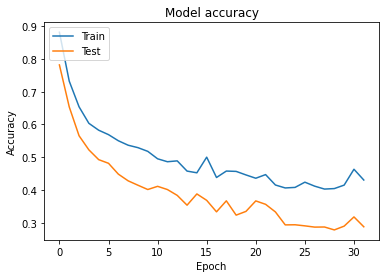

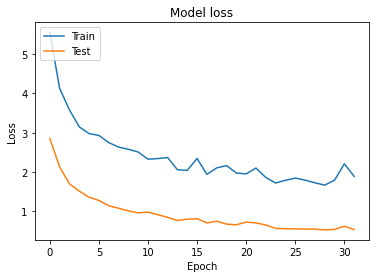

In [17]:
import matplotlib.pyplot as plt
metric = 'mae'
# Plot training & validation accuracy values
plt.plot(history.history[metric])
plt.plot(history.history[f'val_{metric}'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [36]:
model = seq2seq(seq_len, dec_seq_len, num_features, categorical_details=cat_dict, hidden_size=128, 
                teacher_forcing=True)

output shape (None, 28, 1)
output dec shape  (None, 28, 128)


In [39]:
from keras.models import load_model
model.load_weights('train/weights1.h5', by_name=True)


In [56]:
model.get_layer

<bound method Network.get_layer of <tensorflow.python.keras.engine.training.Model object at 0x000002376221F080>>

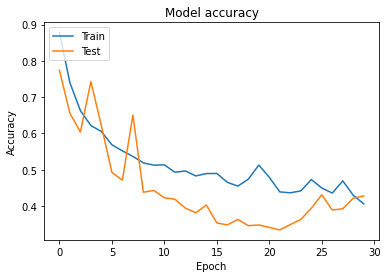

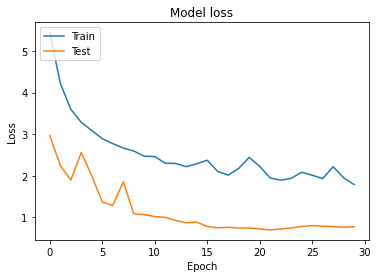

In [30]:
import matplotlib.pyplot as plt
metric = 'mae'
# Plot training & validation accuracy values
plt.plot(history.history[metric])
plt.plot(history.history[f'val_{metric}'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model()

In [20]:
! pip install matplotlib

  Using cached https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl


In [ ]:
import pickle
with open('history.pkl', 'wb') as f:
    pickle.dump(history, f)